In [1]:

from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd# import everything ml
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import re
import string
from wordcloud import WordCloud
import nltk
from collections import Counter
import contractions
from tqdm import tqdm
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from PIL import Image, ImageFile
from PIL import ImageDraw
import datasets
from datasets import load_dataset
from torch.utils.data import random_split

In [2]:

class DoubleConv(nn.Module):
    def __init__(self, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.LazyConv2d(out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.LazyConv2d(out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.encoder.append(DoubleConv(feature))

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1] * 2)

        # Decoder
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(DoubleConv(feature))  # after concatenation

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)  # upsample
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)
            x = torch.cat((skip_connection, x), dim=1)  # concat
            x = self.decoder[idx + 1](x)  # double conv

        return self.final_conv(x)

Found 15000 files
First 5 files: ['2718_i2.png', '3184_t.png', '0080_i2.png', '2806_h.png', '0689_i2.png']
Found 5000 'h' images in ./data/terrain_reconstruction/_dataset
Found 5000 't' images in ./data/terrain_reconstruction/_dataset
Found 5000 'i' images in ./data/terrain_reconstruction/_dataset


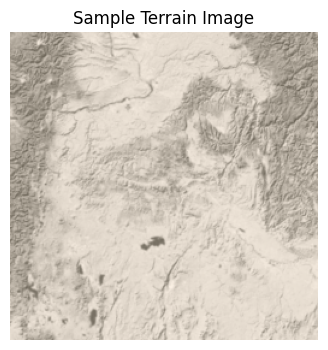

In [3]:
# Dataset path
dataset_path = './data/terrain_reconstruction/_dataset'

all_files = os.listdir(dataset_path)
print(f"Found {len(all_files)} files")
print("First 5 files:", all_files[:5])

# Define dataset class
class TerrainDataset(Dataset):
    def __init__(self, data_dir, image_type, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(data_dir, f) for f in os.listdir(data_dir) if image_type in f
        ]
        print(f"Found {len(self.image_paths)} '{image_type}' images in {data_dir}")
        # self.labels = [
        #     int(os.path.basename(f).split('_')[0]) for f in self.image_paths
        # ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        # label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image

# Define transform
transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Use the correct variable in dataset
heightmap_dataset = TerrainDataset(dataset_path, 'h', transform=transform_pipeline)
terrain_dataset = TerrainDataset(dataset_path, 't', transform=transform_pipeline)
segmentation_dataset = TerrainDataset(dataset_path, 'i', transform=transform_pipeline)

# Example: 80% train, 20% test
train_size = int(0.8 * len(heightmap_dataset))
test_size = len(heightmap_dataset) - train_size
heightmap_train, heightmap_test = random_split(heightmap_dataset, [train_size, test_size])

# Do the same for terrain and segmentation
terrain_train, terrain_test = random_split(terrain_dataset, [train_size, test_size])
segmentation_train, segmentation_test = random_split(segmentation_dataset, [train_size, test_size])


# Function to show a normalized image
def show_tensor_image(tensor_img, title=""):
    # De-normalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = tensor_img * std + mean
    img = img.clamp(0, 1).permute(1, 2, 0).numpy()
    
    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show sample image from terrain dataset
image = next(iter(terrain_dataset))[0]
show_tensor_image(image, title="Sample Terrain Image")

In [4]:
# from unet import UNet
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

#initialize dataloaders
numworkers=16
batchsize =16
# heightmap_loader = DataLoader(heightmap_dataset, batch_size=batchsize, shuffle=True, num_workers=numworkers)
# terrain_loader = DataLoader(terrain_dataset, batch_size=batchsize, shuffle=True, num_workers=numworkers)
# segmentation_loader = DataLoader(segmentation_dataset, batch_size=batchsize, shuffle=True, num_workers=numworkers)
heightmap_train_loader = DataLoader(heightmap_train, batch_size=batchsize, shuffle=True, num_workers=numworkers)
heightmap_test_loader = DataLoader(heightmap_test, batch_size=batchsize, shuffle=False, num_workers=numworkers)
terrain_train_loader = DataLoader(terrain_train, batch_size=batchsize, shuffle=True, num_workers=numworkers)
terrain_test_loader = DataLoader(terrain_test, batch_size=batchsize, shuffle=False, num_workers=numworkers)
segmentation_train_loader = DataLoader(segmentation_train, batch_size=batchsize, shuffle=True, num_workers=numworkers)
segmentation_test_loader = DataLoader(segmentation_test, batch_size=batchsize, shuffle=False, num_workers=numworkers)

train_loader = heightmap_train_loader  # Use heightmap for training

# Initialize UNet model
unet_model = UNet(in_channels=3, out_channels=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(unet_model.parameters(), lr=0.001)


In [8]:
# num_epochs = 2
# for epoch in range(num_epochs):
#     unet_model.train()
#     running_loss = 0.0
    
#     for i, (images) in enumerate(train_loader):
#         images = images.to(device)
        
#         # Forward pass
#         outputs = unet_model(images)
#         loss = criterion(outputs, images)
#         running_loss += loss.item()
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         if (i + 1) % 10 == 0:
#             print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

target_img_loader = heightmap_train_loader  # Use heightmap for testing
input_img_loader = segmentation_train_loader# Use terrain for input
num_epochs = 2
for epoch in range(num_epochs):
    unet_model.train()
    running_loss = 0.0
    
    for i, (images) in enumerate(input_img_loader):
        images = images.to(device)
        target_images = next(iter(target_img_loader))
        target_images = target_images.to(device)
        
        # Forward pass
        outputs = unet_model(images)
        loss = criterion(outputs, target_images)
        running_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [10/250], Loss: 4.5995
Epoch [1/2], Step [20/250], Loss: 4.4353
Epoch [1/2], Step [30/250], Loss: 3.9262
Epoch [1/2], Step [40/250], Loss: 4.4873
Epoch [1/2], Step [50/250], Loss: 5.4027
Epoch [1/2], Step [60/250], Loss: 4.1264
Epoch [1/2], Step [70/250], Loss: 4.0411
Epoch [1/2], Step [80/250], Loss: 3.9506
Epoch [1/2], Step [90/250], Loss: 4.6438
Epoch [1/2], Step [100/250], Loss: 4.3845
Epoch [1/2], Step [110/250], Loss: 10.4453
Epoch [1/2], Step [120/250], Loss: 6.2045


Traceback (most recent call last):
  File "/home/linuxbrew/.linuxbrew/opt/python@3.11/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/linuxbrew/.linuxbrew/opt/python@3.11/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/linuxbrew/.linuxbrew/opt/python@3.11/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/linuxbrew/.linuxbrew/opt/python@3.11/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/linuxbrew/.linuxbrew/opt/python@3.11/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-z0vou_37'


Epoch [1/2], Step [130/250], Loss: 4.4498
Epoch [1/2], Step [140/250], Loss: 4.2253
Epoch [1/2], Step [150/250], Loss: 3.6775
Epoch [1/2], Step [160/250], Loss: 3.8931
Epoch [1/2], Step [170/250], Loss: 4.0177
Epoch [1/2], Step [180/250], Loss: 4.4597
Epoch [1/2], Step [190/250], Loss: 3.6383
Epoch [1/2], Step [200/250], Loss: 3.9012
Epoch [1/2], Step [210/250], Loss: 4.6568


Traceback (most recent call last):
  File "/home/linuxbrew/.linuxbrew/opt/python@3.11/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/linuxbrew/.linuxbrew/opt/python@3.11/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/linuxbrew/.linuxbrew/opt/python@3.11/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/linuxbrew/.linuxbrew/opt/python@3.11/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/linuxbrew/.linuxbrew/opt/python@3.11/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-__68827h'


Epoch [1/2], Step [220/250], Loss: 4.3927
Epoch [1/2], Step [230/250], Loss: 3.3660
Epoch [1/2], Step [240/250], Loss: 4.4891
Epoch [1/2], Step [250/250], Loss: 3.9489
Epoch [2/2], Step [10/250], Loss: 4.0913
Epoch [2/2], Step [20/250], Loss: 4.5311
Epoch [2/2], Step [30/250], Loss: 3.8215
Epoch [2/2], Step [40/250], Loss: 3.3667
Epoch [2/2], Step [50/250], Loss: 3.8657
Epoch [2/2], Step [60/250], Loss: 3.5372
Epoch [2/2], Step [70/250], Loss: 2.5517
Epoch [2/2], Step [80/250], Loss: 3.6860
Epoch [2/2], Step [90/250], Loss: 3.6731
Epoch [2/2], Step [100/250], Loss: 4.2672
Epoch [2/2], Step [110/250], Loss: 3.4464
Epoch [2/2], Step [120/250], Loss: 3.4372
Epoch [2/2], Step [130/250], Loss: 3.5966
Epoch [2/2], Step [140/250], Loss: 3.4143
Epoch [2/2], Step [150/250], Loss: 4.6935
Epoch [2/2], Step [160/250], Loss: 4.0084
Epoch [2/2], Step [170/250], Loss: 4.1286
Epoch [2/2], Step [180/250], Loss: 5.0924
Epoch [2/2], Step [190/250], Loss: 2.7357
Epoch [2/2], Step [200/250], Loss: 3.1811
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..1.9428324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


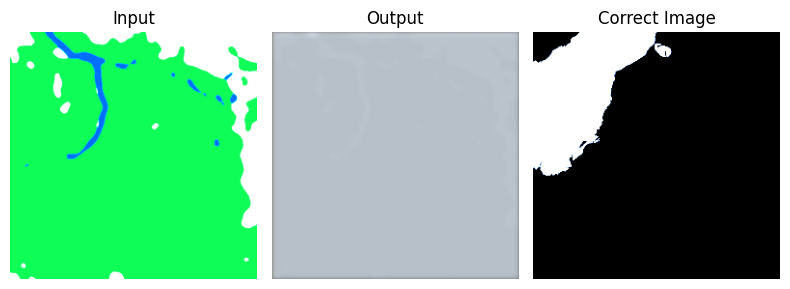

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..1.9428324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.2489083..2.64].


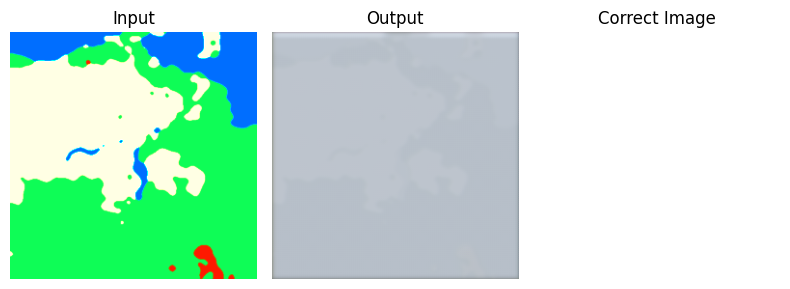

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..1.9428324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


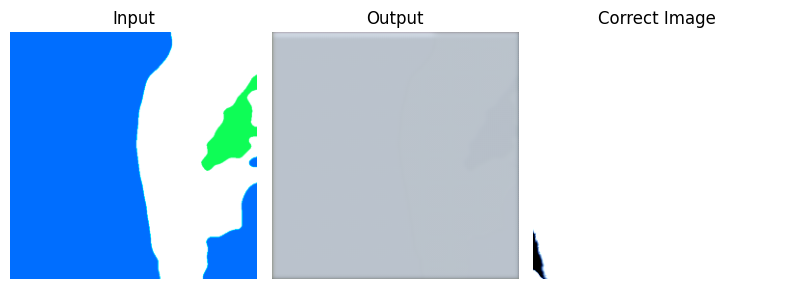

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..1.9428324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


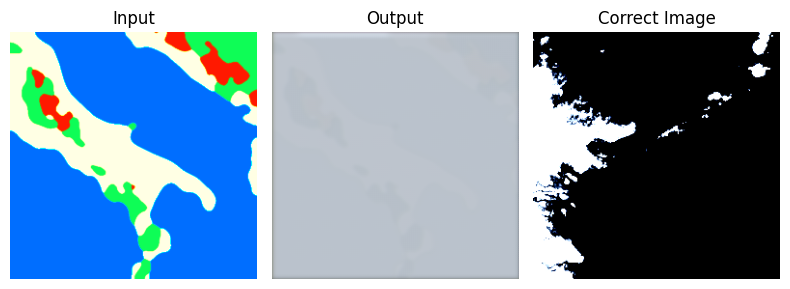

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..1.9428324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.2489083..2.64].


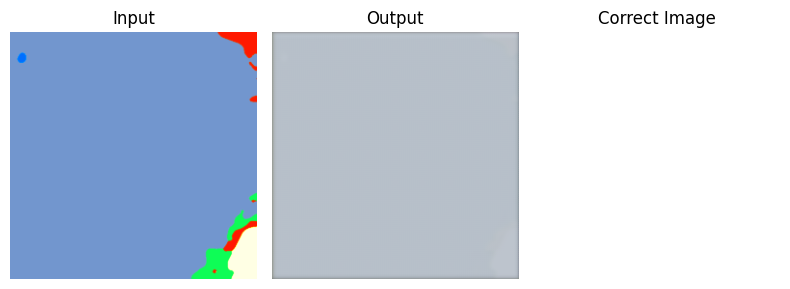

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..1.9428324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


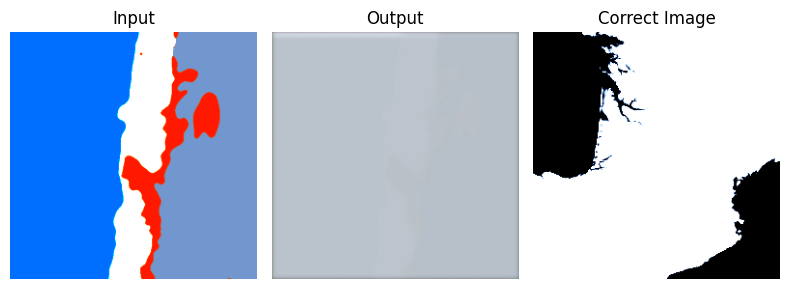

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..1.9428324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].


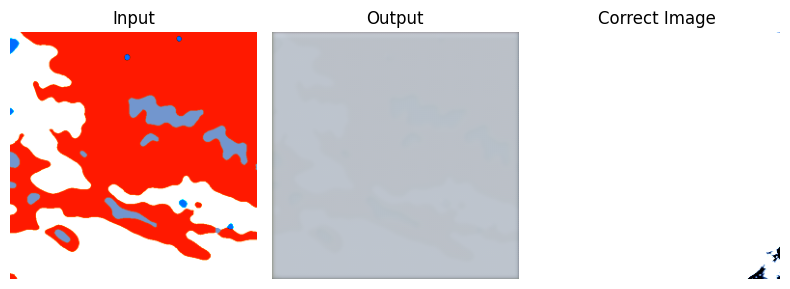

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..1.9428324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


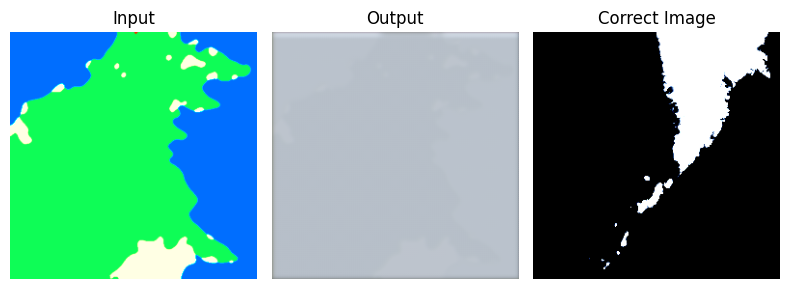

In [20]:
def test_model(model, dataloader, correct_item_dataloader, device, save_output=False, output_dir='test_outputs'):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    
    with torch.no_grad():
        for idx, (images) in enumerate(dataloader):
            images = images.to(device)
            correct_image = next(iter(correct_item_dataloader))

            outputs = model(images)

            # If using sigmoid or BCE/MSE outputs
            outputs = torch.sigmoid(outputs)
            # Move to CPU and convert to numpy
            inputs_np = images.cpu().permute(0, 2, 3, 1).numpy()
            outputs_np = outputs.cpu().permute(0, 2, 3, 1).clamp(0,1).numpy()
            correct_image_np = correct_image.cpu().permute(0, 2, 3, 1).numpy()

            for i in range(min(8, images.size(0))):  # Show/save up to 4 samples
                fig, axs = plt.subplots(1, 3, figsize=(8, 4))
                axs[0].imshow(inputs_np[i])
                axs[0].set_title("Input")
                axs[1].imshow(outputs_np[i])
                axs[1].set_title("Output")
                axs[2].imshow(correct_image_np[i])
                axs[2].set_title("Correct Image")
                for ax in axs:
                    ax.axis("off")
                plt.tight_layout()

                if save_output:
                    plt.savefig(f"{output_dir}/sample_{idx}_{i}.png")
                    plt.close()
                else:
                    plt.show()
            
            break  # only first batch for quick test
        
test_model(unet_model,segmentation_train_loader, heightmap_train_loader, device)